In [6]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
# torch.cuda.set_device(1)
# torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [7]:
torch.cuda.get_device_name(torch.cuda.current_device())

'GeForce RTX 2070'

In [8]:
df = pd.read_csv('dinosaurs.csv', header=None)

In [9]:
class Layer(torch.nn.Module):
    def __init__(self, in_feat, out_feat, activation_func=torch.sigmoid):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(in_feat, out_feat, requires_grad=True))
        self.b = torch.nn.Parameter(torch.randn(1, out_feat, requires_grad=True))
        self.activation_func = activation_func
        
    def forward(self, x):
        return self.activation_func(x @ self.w + self.b)
    
    
class RNN(torch.nn.Module):
    def __init__(self, in_feat, out_feat, mem_size):
        super().__init__()
        self.recurrent_layer = Layer(in_feat + mem_size, mem_size)
        self.classifier = Layer(mem_size, out_feat)
        self.mem_size = mem_size
        self.in_feat = in_feat
        self.out_feat = out_feat
        
    def forward(self, x):
        """
        x is a tensor where each row is a token
        """
        out = []
        memory = torch.zeros(1, self.mem_size)
        
        for t in range(x.shape[0]):
            memory = self.recurrent_layer(torch.cat([x[[t]], memory], axis=1))
            out.append(self.classifier(memory))
        
        return torch.cat(out, axis=0)
    
    def Generate(self, start='{', max_len=20, rand_factor=0.1):
        memory = torch.randn(1, self.mem_size) * rand_factor
        x_0 = torch.zeros(1, 28)
        x_0[0, ord(start) - ord('a')] = 1
        x = [x_0]
        
        for t in range(max_len):
            memory = self.recurrent_layer(torch.cat([x[t], memory], axis=1))
            out = torch.argmax(self.classifier(memory))
            x_new = torch.zeros(1, 28)
            x_new[0, out] = 1
            x.append(x_new)
            if out == 26:
                break
                
        x = torch.cat(x, axis=0)
        return ''.join(list(map(lambda c: chr(c+ord('a')), torch.argmax(x, axis=1))))

class Two_Layer_RNN(torch.nn.Module):
    def __init__(self, in_feat, out_feat):
        super().__init__()
        self.rnn_0 = RNN(in_feat, 28, 64)
        self.rnn_1 = RNN(28, out_feat, 64)
        
    def forward(self, x):
        z_1 = self.rnn_0(x)
        out = self.rnn_1(z_1)
        return out


In [10]:
def OneHot(word):
    word = '{' + word + '|'
    a = ord('a')
    codes = list(map(lambda x: ord(x) - a, word))
    encoding = torch.zeros([len(word), 28])
    encoding[range(len(word)),codes] += 1
        
    return encoding

In [11]:
OneHot('test')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [124]:
model = RNN(28, 28, 56)
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3, )

In [130]:
iterations=250
losses = [np.inf]
batch_size = 5
for i in range(iterations):
    print('{:>5} | {:>12.3}\r'.format(i, losses[-1]), end='')
    dinos = df[0].sample(batch_size).values
    loss = 0
    for dino in dinos:
        x = OneHot(dino)
        x_hat = model(x)
        loss = loss_func(x_hat[:-1], torch.argmax(x[1:], axis=1))
        loss.backward()
        losses.append(loss.detach())
    optim.step()
    optim.zero_grad()
    

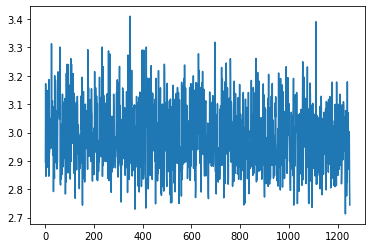

In [131]:
plt.plot(losses)

In [132]:
''.join(list(map(lambda c: chr(c+ord('a')), torch.argmax(x_hat, axis=1))))

'asaanananasnanan'

In [133]:
print(df[0][5])
x_hat = model.forward(OneHot(df[0][5]))
print(''.join(list(map(lambda c: chr(c+ord('a')), torch.argmax(x_hat, axis=1)))))

abydosaurus
asaasaasaanan


In [154]:
model.Generate(start='r', rand_factor=100)

'rpaasanananananananan'

In [86]:
class LSTM(torch.nn.Module):
    def __init__(self, size_in, size_out, size_long, size_short):
        super().__init__()
        size_cat = size_in + size_short
        self.forget_gate = Layer(size_cat, size_long, torch.sigmoid)
        self.memory_gate = Layer(size_cat, size_long, torch.sigmoid)
        self.memory_tanh = Layer(size_cat, size_long, torch.tanh)
        self.recall_gate = Layer(size_cat, size_short, torch.sigmoid)
        self.recall_tanh = Layer(size_long, size_short, torch.tanh)
        self.output_relu = Layer(size_short, size_out, lambda z: z)
        self.size_short = size_short
        self.size_long = size_long
        
    def forward(self, x):
        memory_long  = torch.zeros((1, self.size_long))
        memory_short = torch.zeros((1, self.size_short))
        out = []
        
        for t in range(x.shape[0]):
            x_t = x[[t], :]
            z_t = torch.cat([x_t, memory_short], axis=1)
            
            forget_gate = self.forget_gate(z_t)
            
            memory_long = memory_long * forget_gate
            
            memory_gate = self.memory_gate(z_t)
            memory_tanh = self.memory_tanh(z_t)
            memory = memory_gate * memory_tanh
            
            memory_long = memory_long + memory
            
            recall_gate = self.recall_gate(z_t)
            recall_tanh = self.recall_tanh(memory_long)
            
            memory_short = recall_gate * recall_tanh
            
            y_hat = self.output_relu(memory_short)
            out.append(y_hat)
        return torch.cat(out, axis=0)
    
    def Generate(self, start, stop=0, rand_factor=1, max_t=20):
        memory_long  = torch.randn((1, self.size_long)) * rand_factor
        memory_short = torch.randn((1, self.size_short)) * rand_factor
        out = [start]
        while (out[-1] != stop).any() and (len(out) <= max_t):
            z_t = torch.cat([out[-1], memory_short], axis=1)
            forget_gate = self.forget_gate(z_t)
            
            memory_long = memory_long * forget_gate
            
            memory_gate = self.memory_gate(z_t)
            memory_tanh = self.memory_tanh(z_t)
            memory = memory_gate * memory_tanh
            
            memory_long = memory_long + memory
            
            recall_gate = self.recall_gate(z_t)
            recall_tanh = self.recall_tanh(memory_long)
            
            memory_short = recall_gate * recall_tanh
            
            y_hat = self.output_relu(memory_short)
            zeros = torch.zeros((1, x.shape[1]))
            zeros[0, torch.argmax(y_hat, dim=1)] = 1
            out.append(zeros)
            
        return torch.cat(out, axis=0)
        

In [147]:
model = LSTM(28, 28, 10, 10)
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-2, )

In [148]:
iterations=2000
losses = [np.inf]
batch_size = 5
for i in range(iterations):
    print('{:>5} | {:>12.3}\r'.format(i, losses[-1]), end='')
    dinos = df[0].sample(batch_size).values
    loss = 0
    for dino in dinos:
        x = OneHot(dino)
        x_hat = model(x)
        loss = loss_func(x_hat[:-1], torch.argmax(x[1:], axis=1))
        loss.backward()
        losses.append(loss.detach())
    optim.step()
    optim.zero_grad()
    

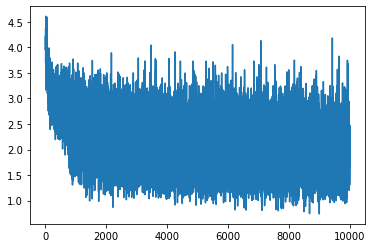

In [149]:
plt.plot(losses)

In [351]:
start = OneHot('{')[[1]]
stop = OneHot('')[[1]]
for i in range(10):
    print(''.join(map(chr, torch.argmax(model.Generate(start, stop, rand_factor=0.5), axis=1) + ord('a'))))

{rachosaurus|
{hon|
{osaurus|
{us|
{nhosaurus|
{ucrachus|
{rosaurus|
{losaurus|
{us|
{hurus|
